# Imports

In [218]:
import os
import sys
sys.path.insert(0,'..')
import torch
import pickle
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import time

from utils import iterate_minibatches, ResultsContainer
from confusionmatrix import ConfusionMatrix
from metrics_mc import gorodkin, IC
from model import ABLSTM


def model_load(fn):
    global model, criterion, optimizer
    with open(fn, 'rb') as f:
        model, criterion, optimizer = torch.load(f, map_location='cpu')
        



## Load model and results

In [221]:
n_class = 10
batch_size = int(128)
seq_len = 1000
n_hid = int(256)
result_name="Mar_19-14_30"


model_load("../save/best_model_"+result_name+".pt")

with open("../save/best_results_"+result_name, 'rb') as f:
    results = pickle.load(f)

# epochs
epochs = results.epochs
loss_training = results.loss_training
loss_validation = results.loss_validation
acc_training = results.acc_training
acc_validation = results.acc_validation

# final
alphas = results.alphas
targets = results.targets
seq_lengths = results.seq_lengths

test_acc = results.test_acc
test_mem_acc = results.test_mem_acc

cf_test = results.cf_test
cf_mem_test = results.cf_mem_test

best_cf_val = None
best_val_acc = None

# Results

In [222]:
print(model)

params = list(model.parameters()) + list(criterion.parameters())
total_params = sum(x.size()[0] * x.size()[1] if len(x.size()) > 1 else x.size()[0] for x in params if x.size())
print('Model total parameters:', total_params)

ABLSTM(
  (in_drop): Dropout2d(p=0.2)
  (drop): Dropout(p=0.5)
  (convs): ModuleList(
    (0): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
    (1): Conv1d(20, 20, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): Conv1d(20, 20, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): Conv1d(20, 20, kernel_size=(9,), stride=(1,), padding=(4,))
    (4): Conv1d(20, 20, kernel_size=(15,), stride=(1,), padding=(7,))
    (5): Conv1d(20, 20, kernel_size=(21,), stride=(1,), padding=(10,))
  )
  (cnn_final): Conv1d(120, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm): LSTM(128, 256, batch_first=True, bidirectional=True)
  (relu): ReLU()
  (attn): Attention(
    (linear_in): Linear(in_features=512, out_features=256, bias=True)
    (linear_att): Linear(in_features=256, out_features=1, bias=False)
  )
  (dense): Linear(in_features=512, out_features=512, bias=True)
  (label): Linear(in_features=512, out_features=10, bias=True)
  (mem): Linear(in_features=512, out_features=1, bias=True

## Model loss and accuracy

In [223]:
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

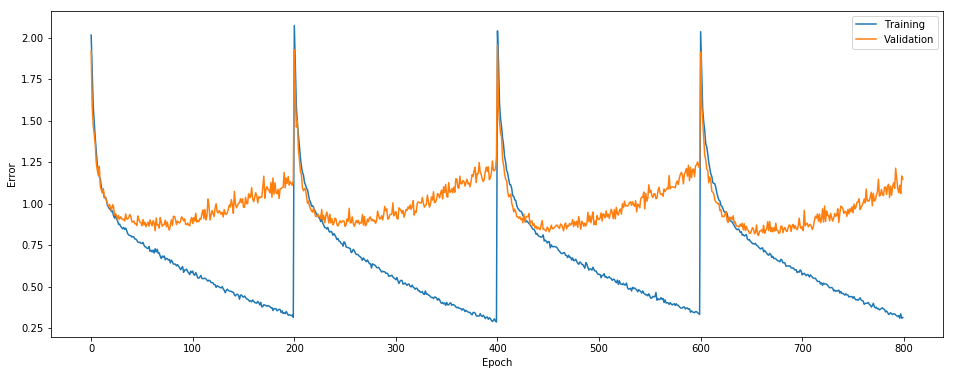

In [224]:
x_axis = range(epochs)
plt.figure(figsize=(16,6))
plt.plot(x_axis,loss_training)
plt.plot(x_axis,loss_validation)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(('Training','Validation'));

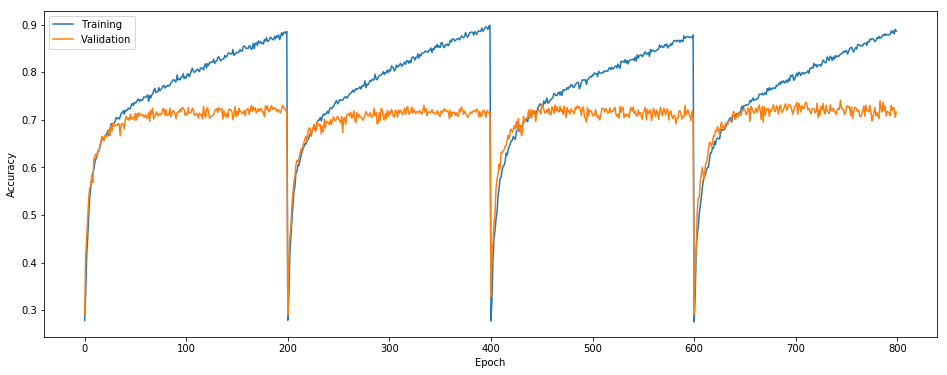

In [225]:
plt.figure(figsize=(16,6))
plt.plot(x_axis,acc_training)
plt.plot(x_axis,acc_validation)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(('Training','Validation'));

## Confusion matrix

In [234]:
print('| Location | acc {:.2f}% | Gorodkin {:2.2f} | IC {:2.2f}' 
          ' |'.format(test_acc*100, gorodkin(cf_test),IC(cf_test)))

print('| Mem/ Sol | acc {:.2f}% | Gorodkin {:2.2f} | IC {:2.2f}' 
          ' |'.format(test_mem_acc*100, gorodkin(cf_mem_test),IC(cf_mem_test)))

| Location | acc 74.89% | Gorodkin 0.70 | IC 0.55 |
| Mem/ Sol | acc 74.89% | Gorodkin 0.81 | IC 0.55 |


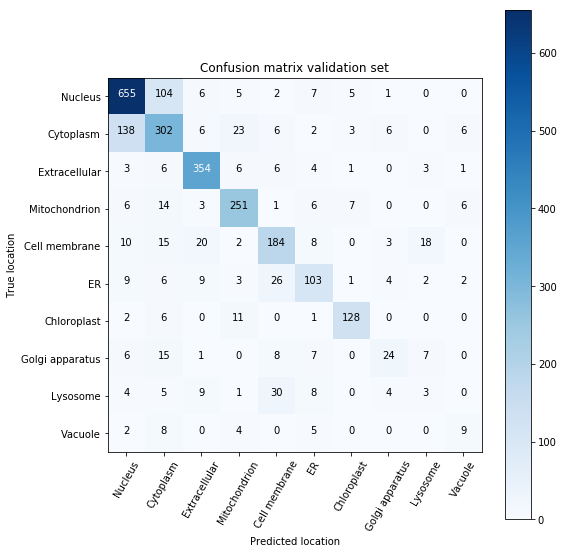

In [236]:
plt.figure(figsize=(8,8))

cmap=plt.cm.Blues   
plt.imshow(cf_test, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix test set')
plt.colorbar()
tick_marks = np.arange(n_class)
classes = ['Nucleus','Cytoplasm','Extracellular','Mitochondrion','Cell membrane','ER',
           'Chloroplast','Golgi apparatus','Lysosome','Vacuole']

plt.xticks(tick_marks, classes, rotation=60)
plt.yticks(tick_marks, classes)

thresh = cf_test.max() / 2.
for i, j in itertools.product(range(cf_test.shape[0]), range(cf_test.shape[1])):
    plt.text(j, i, cf_test[i, j],
             horizontalalignment="center",
             color="white" if cf_test[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True location')
plt.xlabel('Predicted location');

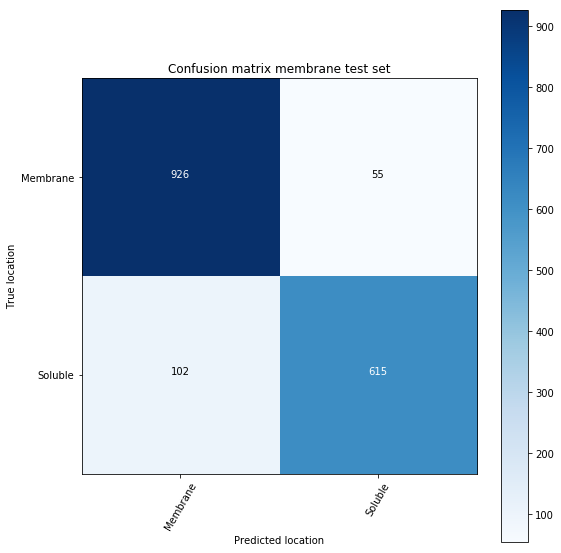

In [239]:
plt.figure(figsize=(8,8))

cmap=plt.cm.Blues   
plt.imshow(cf_mem_test, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix membrane test set')
plt.colorbar()
tick_marks = np.arange(2)
classes_2 = ['Soluble', 'Membrane']

plt.xticks(tick_marks, classes_2, rotation=60)
plt.yticks(tick_marks, classes_2)

thresh = cf_mem_test.max() / 2.
for i, j in itertools.product(range(cf_mem_test.shape[0]), range(cf_mem_test.shape[1])):
    plt.text(j, i, cf_mem_test[i, j],
             horizontalalignment="center",
             color="white" if cf_mem_test[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True location')
plt.xlabel('Predicted location');

## Attention

In [237]:
padded_alphas = np.empty([128,1000])

for i, seq_length in enumerate(seq_lengths):
    
    seq_length = int(seq_length)
    padding = 1000 - seq_length
    first_part = alphas[i][0:seq_length//2]
    second_part = alphas[i][seq_length//2:seq_length]
    padding = np.zeros(padding)
    combined = np.concatenate((first_part, padding, second_part))
    padded_alphas[i] = combined
    
    #if(i<7):
    #    print("seq_len: ", seq_length)
    #    print("first_part: ", len(first_part))
    #    print("second_part: ", len(second_part))
    #    print("padding: ", padding.shape)    
    #    print("combined: ", combined.shape)
    #    print("---")
print("padded_alpha: ", padded_alphas.shape)

padded_alpha:  (128, 1000)


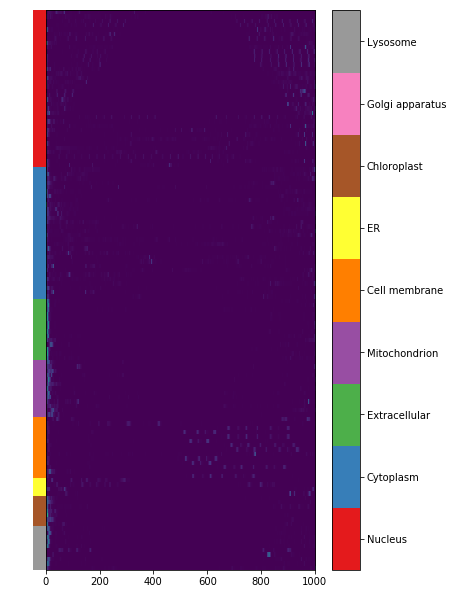

In [238]:
sort_ind = np.argsort(targets)
alphas_1 = padded_alphas[sort_ind]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15));
labels_plot = ax1.imshow(targets[sort_ind].reshape(128,1),cmap=plt.get_cmap('Set1'))
ax1.set_aspect(0.3)
ax1.set_axis_off()
cb = plt.colorbar(labels_plot)
labels = np.arange(0,10,1)
loc = labels + .5
cb.set_ticks(loc)
cb.set_ticklabels(classes)
att_plot = ax2.imshow(alphas_1, aspect='auto')
ax2.yaxis.set_visible(False)
plt.tight_layout(pad=25, w_pad=0.5, h_pad=1.0)

In [ ]:
print(n_class)